## 0. 今日の量子コンピュータの問題

- Noisy Intermediate-Scale Quantum (NISQ) デバイス
    - 量子回路が深くなる（ゲート数が多くなる）ほど、誤差が大きくなる
    - 十分な量子ビット数ではない
- 量子デバイスは特別なゲート演算のみが用意されている
- 特定のqubits間の量子ビット演算(multi qubit operation)しか用意されていない
- それぞれの量子デバイスに対して、量子ソフトウェアツールキットが用意されてる


### 0-1. TKETとは
- Quantum Software Development Kit
- C++で実装
- pythonモジュール　`pytket`で利用可能
- 最適化コンパイラ：　ユーザーフレンドリーな回路→量子デバイスで実行可能な回路に変換可能
    - Language-agnostic (多くの量子プログラミングフレームワーク(qiskit, Cirq, etc)をサポート)
    - Retagetable (多くの量子デバイス(IBM, Honeywell, etc)をサポート)
    - Circuit Optimisation (量子計算時に生じるデバイスエラーの影響を最小化。デバイス依存＆デバイス非依存のものが実装)
    
<img src="fig/tket1.png" width="750">



#### 参照
- [pytket ドキュメント](https://cqcl.github.io/tket/pytket/api/index.html)
- [pytket ユーザーマニュアル](https://cqcl.github.io/pytket/manual/index.html)
- [t|ket⟩ : A Retargetable Compiler for NISQ Devices](https://arxiv.org/abs/2003.10611)

### 0-2. 今回必要となる python パッケージ
Python 3.9.7で動作確認をしています。

|  パッケージ （version） |  概要  |
| :---- | :---- |
|  pytket |  tketを利用するためのpython モジュール  ( available for python3.7 or higher )|
|  pytket-qiskit  |  qiskitを利用するためのpytket-extension  |
|  pytket-braket  |  Amazon Braketを利用するためのpytket-extension  |
|  pytket-qsharp  |  Azure Quantumを利用するためのpytket-extension  |

<img src="fig/tket2.png" width="750">

環境にインストールされていない場合は、以下のセルの＃を取り除き、インストールしてください。

In [1]:
#!pip install pytket
#!pip install pytket-qiskit
#!pip install pytket-braket
#!pip install pytket-qsharp #こちらのパッケージは.net等のインストールが必要です。詳しくは こちら を参照ください。
#!pip install pylatexenc #可視化のためのパッケージ

## 1. 量子回路の作成
ここでは AWSの量子デバイスやシュミレーションを利用できる`braket`,`qiskit`と`tket`でベル状態を作成する。

### 1-1. `braket`でベル状態を作成
$$ |\Psi\rangle = \frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)$$

In [20]:
from braket.circuits import Circuit

aws_bell = Circuit()
aws_bell.h(0)
aws_bell.cnot(0, 1)

print(aws_bell)

T  : |0|1|
          
q0 : -H-C-
        | 
q1 : ---X-

T  : |0|1|


### 1-2. `qiskit`でベル状態を作成

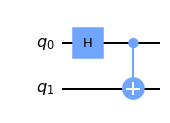

In [21]:
from qiskit import QuantumCircuit

qs_bell = QuantumCircuit(2)
qs_bell.h(0)
qs_bell.cx(0,1)

qs_bell.draw(output='mpl')

### 1-3. `tket`でベル状態を作成

In [22]:
from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter

bell = Circuit(2)
bell.H(0)
bell.CX(0,1)

render_circuit_jupyter(bell)

## 2. 量子回路の交換
pytketでは
- braketで記述した量子回路(`braket.circuits.Circuit`)からtketの量子回路のクラスに変換が可能
- qiskitで記述した量子回路(`qiskit.QuantumCircuit`)からtketの量子回路のクラスに変換が可能
- tketで記述した量子回路からqiskitの量子回路(`braket.circuits.Circuit`)のクラスに変換が可能
- tketで記述した量子回路からqiskitの量子回路(`qiskit.QuantumCircuit`)のクラスに変換が可能
- tketで記述した量子回路と他の量子プログラミング言語での量子回路の交換が可能

参照：[pytket-extensions](https://cqcl.github.io/pytket-extensions/api/index.html) 

### 2-1. `braket`の量子回路から`tket`の量子回路に変換

In [24]:
from pytket.extensions.braket import braket_to_tk

In [31]:
bell1 = braket_to_tk(aws_bell)
render_circuit_jupyter(bell1)

### 2-2. `tket`の量子回路から`braket`の量子回路に変換

In [26]:
from pytket.extensions.braket import tk_to_braket

In [32]:
aws_bell1 = tk_to_braket(bell)
print(aws_bell1[0])

T  : |0|1|2|
            
q0 : -I-H-C-
          | 
q1 : -I---X-

T  : |0|1|2|


### 2-3. `qiskit`の量子回路から`tket`の量子回路に変換

In [29]:
from pytket.extensions.qiskit import qiskit_to_tk

In [34]:
bell2 = qiskit_to_tk(qs_bell)
render_circuit_jupyter(bell2)

### 2-4. `tket`の量子回路から`qiskit`の量子回路に変換

In [28]:
from pytket.extensions.qiskit import tk_to_qiskit

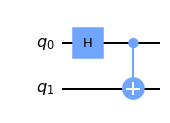

In [35]:
qs_bell1 = tk_to_qiskit(bell)
qs_bell1.draw(output='mpl')

## 3. Braketで記述した量子回路をIBM Quantumのシュミレータで実行

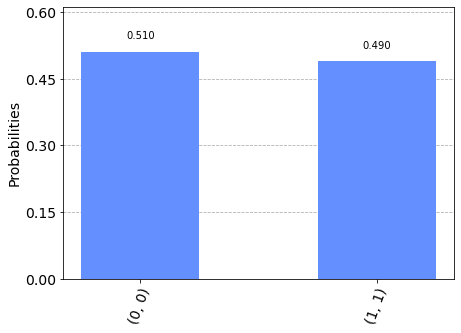

In [38]:
from pytket.extensions.qiskit import AerBackend
backend = AerBackend()
## bell1 : braket circuit -> tket circuit
handle = backend.process_circuit(bell1.measure_all(), n_shots =1000)
result_counts = backend.get_result(handle).get_counts()
plot_histogram(result_counts)

## 再掲
<img src="fig/tket1.png" width="750">

## 4. 量子回路の最適化
例えば、Hゲートを同じビットに連続して作用させるとゲート操作をしていないのと恒等な量子状態が得られます。
<img src="fig/circ.png" width="500">

量子回路が深くなる（ゲート数が多くなる）ほど、誤差が大きくなるNISQ デバイスでは左辺のような状況は除去したい。

その他にも下記のような恒等な関係があります。
<img src="fig/relation.png" width="700">

### 4-1. PauliSimp 関数を利用した、量子回路の最適化
tketには量子回路を最適化する様々な機能が用意されている。
ここでは、PauliSimp 関数を利用した回路の最適化を行う。

（PauliSimp 関数：Pauli ゲートとCliffordゲートで表現された量子回路を出力）

ランダムな量子回路を作成し、回路の深さとCXの深さを数える。

In [59]:
from pytket.pauli import Pauli
from pytket.circuit import PauliExpBox, fresh_symbol, OpType
from pytket.passes import DecomposeBoxes
box = PauliExpBox([Pauli.I, Pauli.Z, Pauli.X, Pauli.Y], fresh_symbol('tm'))
from pytket.utils import Graph
import numpy as np

def get_random_pauli_gadgets(n_qubits, n_pauli_gadgets, max_entangle):
    """ """
    paulis = [Pauli.I, Pauli.X, Pauli.Y, Pauli.Z]
    circ = Circuit(n_qubits)
    for i in range(n_pauli_gadgets):
        ls_paulis = [np.random.choice(paulis) for k in range(max_entangle)]
        if ls_paulis.count(Pauli.Y) % 2 == 0:
            continue
        if len(ls_paulis) - ls_paulis.count(Pauli.I) <= 1:
            continue
        qubits = np.random.choice(
            [i for i in range(n_qubits)], size=max_entangle, replace=False
        )
        box = PauliExpBox(ls_paulis, fresh_symbol('a'))
        circ.add_pauliexpbox(box, sorted(qubits))
    DecomposeBoxes().apply(circ)
    return circ

circ = get_random_pauli_gadgets(
    n_qubits=8, n_pauli_gadgets=300, max_entangle=5
)
print('Circuit depth: ', circ.depth())
print('CX depth: ', circ.depth_by_type(OpType.CX))
render_circuit_jupyter(circ)

Circuit depth:  1207
CX depth:  821


PauliSimp 関数を使って、量子回路の最適化

In [60]:
# Circuit optimization by using compiler passes.
from pytket.passes import PauliSimp
circx = circ.copy()
PauliSimp().apply(circx)
print('Circuit depth: ', circx.depth())
print('CX depth: ', circx.depth_by_type(OpType.CX))
#render_circuit_jupyter(circx)

Circuit depth:  1007
CX depth:  638
